In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import mxnet as mx 
from Symbol.symbol import get_resnet_model
from Symbol.symbol import YOLO_loss
from data_ulti import get_iterator
import cv2 

In [2]:
def decodeBox(yolobox, size, dscale):
    i, j, cx, cy, w, h, cls1, cls2, cls3, cls4 = yolobox
    cxt = j*dscale + cx*dscale
    cyt = i*dscale + cy*dscale
    wt = w*size
    ht = h*size
    cls = np.argmax([cls1, cls2, cls3, cls4])
    return [cxt, cyt, wt, ht, cls]

def bboxdraw(img, label, dscale=32):
    #assert label.shape == (7,7,9)
    size = img.shape[1]
    ilist, jlist = np.where(label[:,:,0]>0.5)
    
    # Create figure and axes
    fig,ax = plt.subplots(1)
    ax.imshow(np.uint8(img))
    for i,j in zip(ilist, jlist): 
        cx,cy,w,h,cls1, cls2, cls3, cls4 = label[i,j,1:]
        cxt, cyt, wt ,ht, cls = decodeBox([i, j, cx,cy,w,h,cls1, cls2, cls3, cls4], size, dscale)
        # Create a Rectangle patch
        rect = patches.Rectangle((cxt-wt/2,cyt-ht/2), wt,ht,linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
    
        name="unkown"
        if cls==0:
            name="car"
        elif cls==1:
            name="pedestrian"
        elif cls==2:
            name="cyclist"
        elif cls==3:
            name="traffic lights"
        plt.text(x=int(cxt-wt/2), y=int(cyt-ht/2), s=str(name), bbox=dict(facecolor='red', alpha=0.5))
    plt.show()

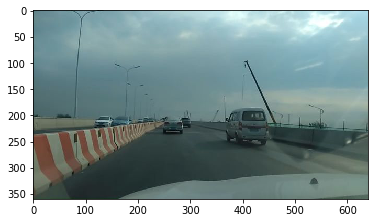

Orignal Img


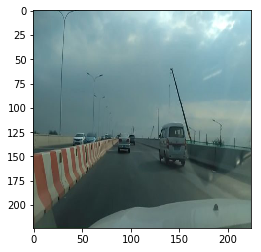

Resize Img


In [3]:
cat = plt.imread("DATA/testing/testing/70125.jpg")
plt.imshow(cat)
plt.show()
print "Orignal Img"
W = 224
H = 224
cat_resize = cv2.resize(cat, (W,H))
plt.imshow(cat_resize)
plt.show()
print "Resize Img"

In [4]:
cat_nd = mx.nd.array(ctx=mx.gpu(0), source_array=cat_resize.transpose((2,0,1)).reshape(1,3,H,W))
print cat_resize.shape
print cat_nd.shape
cat_itr = mx.io.NDArrayIter(data=cat_nd, data_name='data',  batch_size=1)

(224, 224, 3)
(1L, 3L, 224L, 224L)


In [5]:
# get sym 
sym, args_params, aux_params = mx.model.load_checkpoint('drive_full_detect', 300)
logit = sym.get_internals()['logit_output']
mod = mx.mod.Module(symbol=logit, context=mx.gpu(0))
mod.bind(cat_itr.provide_data)
mod.init_params(allow_missing=False, arg_params=args_params, aux_params=aux_params, 
                initializer=mx.init.Xavier(magnitude=2,rnd_type='gaussian',factor_type='in'))
out = mod.predict(eval_data=cat_itr, num_batch=10)

/home/chuck/DLenv/MXNet/local/lib/python2.7/site-packages/mxnet/module/base_module.py:53: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/home/chuck/DLenv/MXNet/local/lib/python2.7/site-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [6]:
#pred->softsing->x/(1+abs(x))
pred = (out.asnumpy()[0]+1)/2
print pred.shape

(7, 7, 9)


Prediction


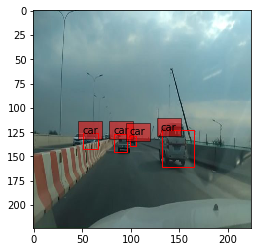

In [7]:
print "Prediction"
bboxdraw(cat_resize, pred)